In [1]:
# replicating observations of https://arxiv.org/abs/2310.13121

import math
import pickle
import random

import jax
import jax.random
import jax.tree as jt
import jax.lax as lax
import jax.numpy as jnp

from typing import NamedTuple

from jax import jit, grad, vmap, value_and_grad
from einops import rearrange, repeat, einsum
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ModelArgs(NamedTuple):
    d: int
    nh: int
    nl: int
    v: int
    l: int


class LayerParams(NamedTuple):
    att_norm: jax.Array
    att_win: jax.Array
    att_wout: jax.Array
    ffn_norm: jax.Array
    ffn_win: jax.Array
    ffn_wout: jax.Array


class ModelParams(NamedTuple):
    wte: jax.Array
    layers: LayerParams
    norm: jax.Array
    wout: jax.Array


def rms_norm(w, x, eps=1e-8):
    z = jnp.float32(x) 
    norm = z * lax.rsqrt(jnp.mean(z * z, -1, keepdims=True) + eps)
    return w * norm.astype(x.dtype)


def attention(args, win, wout, x, mask):
    q, k, v = rearrange(x @ win, 'l (n nh dh) -> n nh l dh', n=3, nh=args.nh)
    scores = q @ k.transpose(0, 2, 1) * (args.d // args.nh) ** -0.5
    heads = jax.nn.softmax(jnp.float32(scores + mask), -1).astype(x.dtype) @ v
    return rearrange(heads, 'nh l dh -> l (nh dh)') @ wout


def transformer(args, params, tokens):
    mask = jnp.triu(jnp.full((args.l, args.l), -jnp.inf), 1)
    wpe = jnp.eye(args.l, args.l)

    def block(x, params):
        h = rms_norm(params.att_norm, x)
        x = x + attention(args, params.att_win, params.att_wout, h, mask)
        h = rms_norm(params.ffn_norm, x)
        return x + jax.nn.relu(h @ params.ffn_win) @ params.ffn_wout, None

    x = jnp.concatenate([params.wte[tokens], wpe], -1)
    x, _ = lax.scan(block, x, params.layers)
    return jnp.float32(rms_norm(params.norm, x) @ params.wout)


def initialize_params(key, args):
    wte_key, out_key, layer_key = jax.random.split(key, 3)
    layer_keys = jax.random.split(layer_key, 4)

    truncated_normal_stddev = .87962566103423978
    d_scale = 1 / (math.sqrt(args.d) * truncated_normal_stddev)
    d_expand_scale = 1 / (math.sqrt(4 * args.d) * truncated_normal_stddev)

    return ModelParams(
        wte=jax.random.truncated_normal(wte_key, -2, 2, (args.v, args.d - args.l)) * d_scale,
        layers=LayerParams(
            att_norm=jnp.ones((args.nl, args.d)),
            att_win=jax.random.truncated_normal(layer_keys[0], -2, 2, (args.nl, args.d, 3 * args.d)) * d_scale,
            att_wout=jax.random.truncated_normal(layer_keys[1], -2, 2, (args.nl, args.d, args.d)) * d_scale,
            ffn_norm=jnp.ones((args.nl, args.d)),
            ffn_win=jax.random.truncated_normal(layer_keys[2], -2, 2, (args.nl, args.d, 4 * args.d)) * d_scale,
            ffn_wout=jax.random.truncated_normal(layer_keys[3], -2, 2, (args.nl, 4 * args.d, args.d)) * d_expand_scale,
        ),
        norm=jnp.ones(args.d),
        wout=jax.random.truncated_normal(out_key, -2, 2, (args.d, args.v)) * d_scale
    )


def adamw(b1, b2, eps, decay, step, lr, params, grads, state):
    m, v = state
    m = jt.map(lambda m, g: b1 * m + (1 - b1) * g, m, grads)
    v = jt.map(lambda v, g: b2 * v + (1 - b2) * g ** 2, v, grads)
    m_ = jt.map(lambda m: m / (1 - b1 ** step), m)
    v_ = jt.map(lambda v: v / (1 - b2 ** step), v)
    params = jt.map(lambda p, m, v: p - lr * (m / (v + eps) ** 0.5 + decay * p), params, m_, v_)
    return params, (m, v)

In [3]:
ctoi = {'<bos>': 0, '<eos>': 1, '+': 2, '=': 3, **{str(i): i + 4 for i in range(10)}}
itoc = {i: c for c, i in ctoi.items()}


def sample_batch(key, batch_size):
    a, b = jax.random.randint(key, (2, batch_size), minval=10000, maxval=99999)
    s = a + b
    batch = []
    for an, bn, sn in zip(a.tolist(), b.tolist(), s.tolist()):
        ai = [ctoi[c] for c in str(an)]
        bi = [ctoi[c] for c in str(bn)]
        si = [ctoi[c] for c in str(sn).zfill(6)]
        example = [0] + ai + [2] + bi + [3] + si + [1]
        batch.append(jnp.array(example))
    return jnp.stack(batch)

In [ ]:
key = jax.random.key(42)

nh = 4
d = 512
nl = 1
v = 4 + 10
l = 20
args = ModelArgs(d, nh, nl, v, l)

key, subkey = jax.random.split(key)
params = initialize_params(subkey, args)
model = vmap(partial(transformer, args), (None, 0))

b1 = 0.9
b2 = 0.999
eps = 1e-8
decay = 0.01

optimizer = partial(adamw, b1, b2, eps, decay)
opt_state = jt.map(jnp.zeros_like, (params, params))

max_lr = 3e-4
min_lr = 1e-4
warmup_steps = 200

batch_size = 128
steps = 3000


def get_lr(step):
    if step < warmup_steps:
        lr = max_lr * step / warmup_steps
    else:
        progress = (step - warmup_steps) / (steps - warmup_steps)
        lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + jnp.cos(jnp.pi * progress))
    return lr

In [5]:
def loss_fn(params, examples):
    targets = examples[:, 13:] 
    logits = model(params, examples)[:, 12:-1]
    target_logits = logits[jnp.arange(batch_size)[:, None], jnp.arange(7)[None], targets]
    aux_losses = jnp.mean(jax.nn.logsumexp(logits, -1) - target_logits, 0)
    return aux_losses.mean(), aux_losses


@jit
def train_step(step, lr, params, opt_state, examples):
    (loss, aux_losses), grads = value_and_grad(loss_fn, has_aux=True)(params, examples)
    params, opt_state = optimizer(step, lr, params, grads, opt_state)
    return loss, aux_losses, params, opt_state

In [6]:
losses = []
digit_losses = []
step = 0

In [7]:
for _ in range(steps):
    step += 1

    key, subkey = jax.random.split(key)
    examples = sample_batch(subkey, batch_size)
    loss, aux_losses, params, opt_state = train_step(step, get_lr(step), params, opt_state, examples)

    losses.append(float(loss))
    digit_losses.append(aux_losses)

    if step % 50 == 0:
        print(f'step {step:4d}\tloss {losses[-1]:11.7f}')

step   50	loss   1.7241988
step  100	loss   1.6229380
step  150	loss   1.5233546
step  200	loss   1.4776038
step  250	loss   1.4115512
step  300	loss   0.6732493
step  350	loss   0.4458478
step  400	loss   0.4146523
step  450	loss   0.3826647
step  500	loss   0.3190757
step  550	loss   0.2144933
step  600	loss   0.1454737
step  650	loss   0.1107352
step  700	loss   0.1142416
step  750	loss   0.0983930
step  800	loss   0.0716825
step  850	loss   0.1164371
step  900	loss   0.0535531
step  950	loss   0.0443277
step 1000	loss   0.0518025
step 1050	loss   0.0432884
step 1100	loss   0.0601113
step 1150	loss   0.0492822
step 1200	loss   0.0323911
step 1250	loss   0.0233557
step 1300	loss   0.0319636
step 1350	loss   0.0226536
step 1400	loss   0.0259255
step 1450	loss   0.0310409
step 1500	loss   0.0276486
step 1550	loss   0.0321262
step 1600	loss   0.0203396
step 1650	loss   0.0198992
step 1700	loss   0.0136852
step 1750	loss   0.0221445
step 1800	loss   0.0206229
step 1850	loss   0.0133409
s

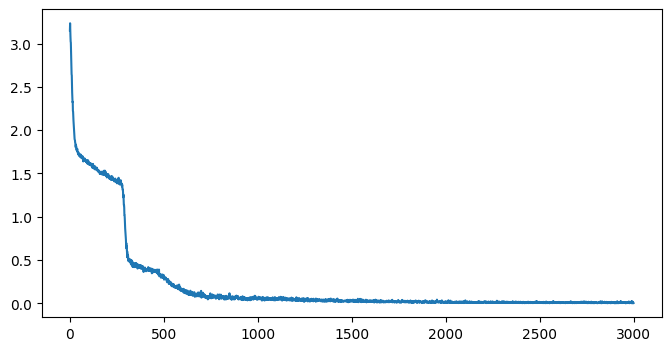

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.show()

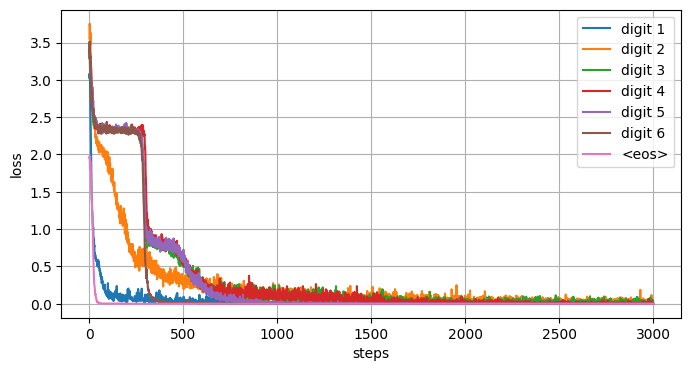

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(digit_losses)
plt.legend(['digit ' + str(i) for i in range(1, 7)] + ['<eos>'])
plt.xlabel('steps')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [12]:
# it's not really val acc because we're not ensuring batches don't 
# intersect with train examples here, but there are 10B pairs and we
# only train on 3000 * 128 = 384000 examples

val_key = jax.random.key(69)
val_set = jnp.concatenate([sample_batch(subkey, 512) for subkey in jax.random.split(val_key, 20)])

n_matches = 0
batch_size = 256

for i in range(0, len(val_set), batch_size):
    batch = val_set[i:i + batch_size]
    targets = batch[:, 13:]
    logits = model(params, batch)[:, 12:-1]
    n_matches += int((jnp.argmax(logits, -1) == targets).sum())

print(f'{100 * n_matches / (len(val_set) * 7):4.2f}%')

99.66%


In [13]:
a = 34789
b = 96674

prompt = '<bos>' + str(a).zfill(5) + '+' + str(b).zfill(5) + '='
ai, bi = [ctoi[c] for c in str(a).zfill(5)], [ctoi[c] for c in str(b).zfill(5)]
tokens = jnp.concatenate([jnp.array([0] + ai + [2] + bi + [3]), jnp.int32(jnp.zeros(7))])

print(prompt + str(a + b).zfill(6) + '<eos>')
print(prompt, end='')

l = 13
for step in range(7):
    key, subkey = jax.random.split(key)
    logits = jit(partial(transformer, args, params))(tokens)
    next_token = logits[l + step - 1].argmax()
    tokens = tokens.at[l + step].set(next_token)
    print(itoc[int(next_token)], end='')
print()

<bos>34789+96674=131463<eos>
<bos>34789+96674=131463<eos>


In [14]:
pickle.dump(params, open('model_params.pkl', 'wb'))